<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/SMART_CLAIR/blob/main/NOGA_SmartGrid_with_CityLearn_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the previous notebooks, we have gotten familier with the citylearn environment and analyzed its data. It is now timw to see how we perform decision making using various AI methods and how we optimize the agent's behavior.



In a single agent setting, given the environment, we need an agent- i.e., a decision making procedure, that decides at each time step, what is the right action to perform. In the citylearn setting this can correspond to a single procumer deciding about its battery charging/discharging policy when it consider the other elements of the grid as part of the (non-stationary environment)

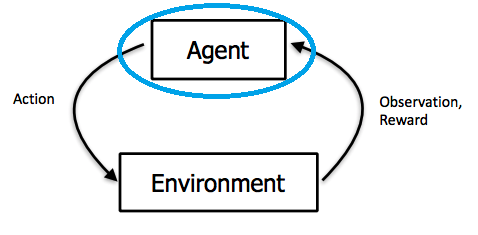

Under some circumstances it makes sense to model the environment as a multi-agent setting. This includes settings in which there are multiple agents with possibly non-aligned rewards, settings in which the behavoir of other

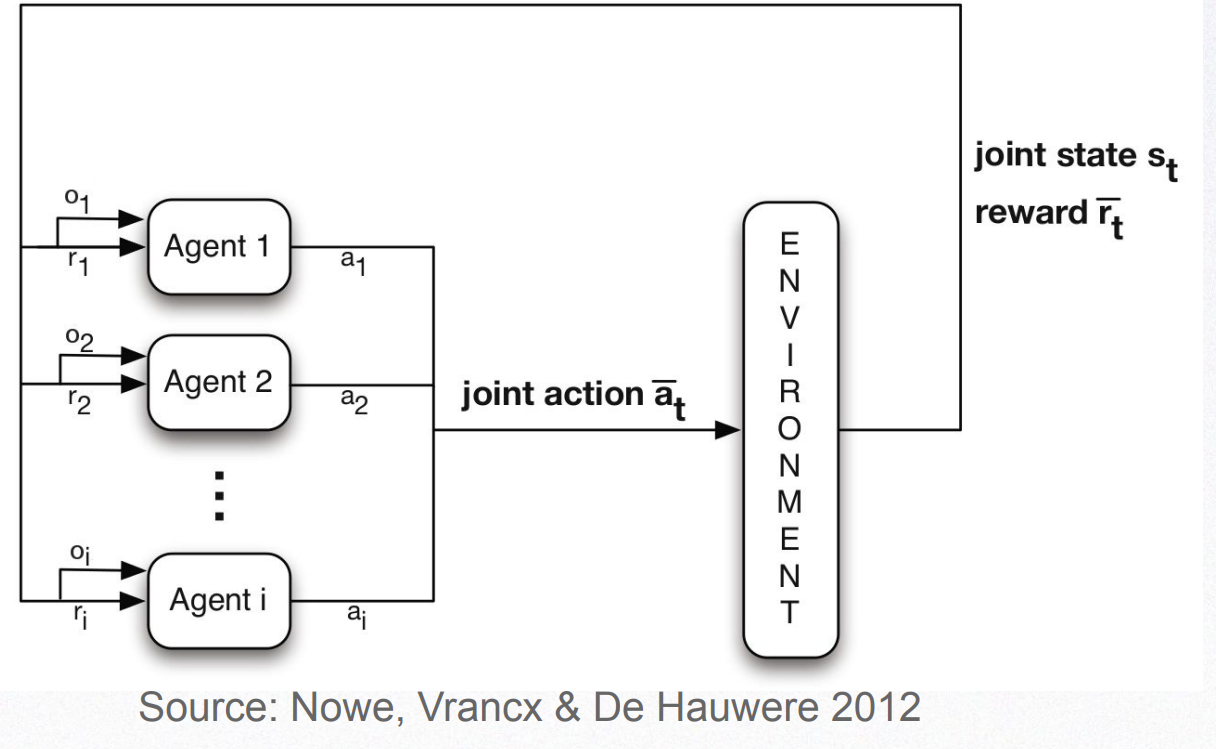

<a name="software-requirements"></a>
# Software Requirements
---

This section installs and imports the software packages that will be used in the remainder of the tutorial. We start off by comparing the Python version of this current environment. CityLearn and its dependencies will work with `python>=3.7.x`

The Python version of this environment is:

In [1]:
!python --version


Python 3.10.12


To be able to run a simulation we need to install the environmnet and some libraries we will use.

In [2]:
!pip install -q CityLearn # the -q argument is for not printing the installation process to the screen.

                          # please ignore (if occurs) the following installation error "ERROR: pip's dependency resolver..."
                          # which is a results of torch version being uncompatible with colab,
                          # as long as we do not use PyTorch (in example, for Reinforcement Learning) you
                          # shouldn't be concerned abount it.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 98.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 1.3.5 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.0

We can also instal a specific version if needed

In [ ]:
# The environment we will be working with
#!pip install CityLearn==1.8.0


The following Python packages are required:

In [3]:

# for installing packages using legacy code
!pip install setuptools==65.5.0

# For participant interactions (buttons)
!pip install ipywidgets==7.7.2

# To generate static figures
!pip install matplotlib==3.5.3
!pip install seaborn==0.12.2

# For visualization
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb

# Provide standard RL algorithms
!pip install "stable-baselines3[extra]>=2.0.0a4"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.7
    Uninstalling jupyterlab-widgets-3.0.7:
      Successfully uninstalled jupyterlab-widgets-3.0.7
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,014 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,064 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/

# Running a Simulation
---




BLA-BLA - what it means to run a simulation

**Step \#1: Initialize the CityLearn Environment**


To initialize an instance of the CityLearn environment we need to call the `citylearn.citylearn.CityLearnEnv.__init__` method and process the data using the `schema` file.



In [4]:
from citylearn.citylearn import CityLearnEnv

In [16]:
import matplotlib.pyplot as plt
import random


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Decide which dataset to use (e.g.'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_all'). To start off, it's best to use the phase_1 dataset - so that things run quickly.

In [17]:
dataset_name = 'citylearn_challenge_2022_phase_1'
#dataset_name = 'citylearn_challenge_2022_phase_all'

We initialize the CityLearn environment with the data set.


In [18]:
env = CityLearnEnv(dataset_name)

TODO: Add a random agent that performs actions

In [23]:
obs_elements = []
for item in env.schema['observations'].items():
  if item[1]['active'] == True:
    print(item[0])

month
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
non_shiftable_load
solar_generation
electrical_storage_soc
net_electricity_consumption
electricity_pricing
electricity_pricing_predicted_6h
electricity_pricing_predicted_12h
electricity_pricing_predicted_24h


In [25]:
# reset the environment
joint_observation = env.reset()

n_steps = 96      # set the number of steps (hours in the simulation, i.e. 24 is a whole single day)
solargen_obs_idx = -7      # the index of the observation variable to plot (-6 => "electrical_storage_soc"
                  #                                                -7 => "solar_generation"...)
net_con_idx = -5
building_i = 0    # index of the building for which to plot the data

environment_data_to_plot = [] # constainer used to collect data during execution
performance_data_to_plot = []
n_buildings = len(joint_observation)  # number of buildings in the environment

# add the initial observation to the data
environment_data_to_plot.append(joint_observation[building_i][solargen_obs_idx])
performance_data_to_plot.append(joint_observation[building_i][net_con_idx])


We will now run a simulation using random action selection as the decision making process.

In [26]:
# run through the environment manually
for _ in range(n_steps - 1):
  # sample random actions for all buildings
  joint_action = [[random.uniform(-1, 1)] for _ in range(n_buildings)]

  # step the environmnet
  next_joint_observation, reward, info, done = env.step(joint_action)

  # collect the data
  environment_data_to_plot.append(next_joint_observation[building_i][solargen_obs_idx])
  performance_data_to_plot.append(next_joint_observation[building_i][net_con_idx])


The step action



```

    def step(self, actions: List[List[float]]) -> Tuple[List[List[float]], List[float], bool, dict]:
        """Apply actions to `buildings` and advance to next time step.


        actions = self.__parse_actions(actions)

        for building, building_actions in zip(self.buildings, actions):
            building.apply_actions(**building_actions)

        self.next_time_step()
        reward = self.reward_function.calculate()
        self.__rewards.append(reward)
        return self.observations, reward, self.done, self.get_info()

```



In [27]:
print(environment_data_to_plot[0])
print(performance_data_to_plot[0])

0.0
2.2758


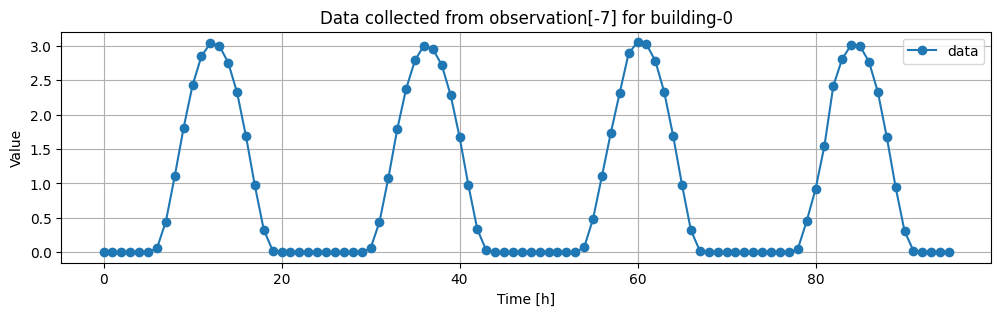

In [28]:
# plotting the data collected
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_title(f"Data collected from observation[{solargen_obs_idx}] for building-{building_i}")
ax.plot(range(n_steps), environment_data_to_plot, '-o', label='data')
ax.set_xlabel("Time [h]")
ax.set_ylabel("Value")
ax.grid()
ax.legend()
plt.show()

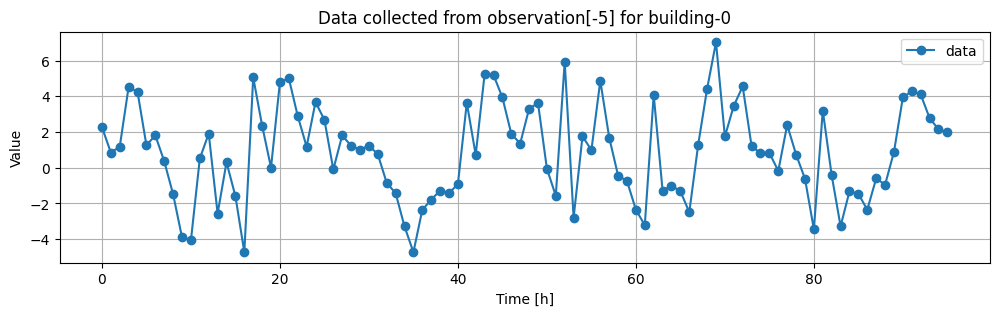

In [29]:
# plotting the data collected
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_title(f"Data collected from observation[{net_con_idx}] for building-{building_i}")
ax.plot(range(n_steps), performance_data_to_plot, '-o', label='data')
ax.set_xlabel("Time [h]")
ax.set_ylabel("Value")
ax.grid()
ax.legend()
plt.show()

# Evaluating Performance Using Key Performance Indicators (KPI)

TODO: remind that this is only a partial list of the KPIs

We evaluate the control agents' performance using six key performance indicators (KPIs) that are to be **minimized**: electricity consumption, cost, carbon emissions, average daily peak, ramping, and (1 - load factor). average daily peak, ramping and (1 - load factor) are district-level KPIs that are calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. electricity consumption, cost, and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

Electricity consumption is defined as the sum of imported electricity $E_h^{\textrm{building}}$ as the objective is to minimize the energy consumed but not profit from the excess generation.

$$
    \textrm{electricity consumption} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \right)}
$$

Cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $E_h^{\textrm{building}} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times O_h \right )}
$$

Average daily peak, is defined as the mean of the daily $E_h^{\textrm{district}}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

Ramping is defined as the absolute difference of consecutive $E_h^{\textrm{district}}$. It represents the smoothness of the district’s load profile where low ramping means there is gradual increase in grid load even after self-generation becomes unavailable in the evening and early morning. High ramping means abrupt change in grid load that may lead to unscheduled strain on grid infrastructure and blackouts as a result of supply deficit.

$$
    \textrm{ramping} = \sum_{h=0}^{n-1}  \lvert E_{h}^{\textrm{district}} - E_{h - 1}^{\textrm{district}} \rvert
$$

Load factor is defined as the average ratio of monthly average and peak $E_{h}^{\textrm{district}}$ where $m$ is the month index, $d$ is the number of days in a month and $n$ is the number of months. load factor represents the efficiency of electricity consumption and is bounded between 0 (very inefficient) and 1 (highly efficient) thus, the goal is to maximize the load factor or in the same fashion as the other KPIs, minimize (1 - load factor).

$$
    \textrm{1 - load factor}  = \Big(
        \sum_{m=0}^{n - 1} 1 - \frac{
            \left (
                \sum_{h=0}^{d - 1} E_{d \cdot m + h}^{\textrm{district}}
            \right ) \div d
        }{
            \textrm{max} \left (E_{d \cdot m}^{\textrm{district}}, \dots, E_{d \cdot m + d - 1}^{\textrm{district}} \right )
    }\Big) \div n
$$

For the remainder of the paper, the KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control.

$$
    \textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

The `evaluate` function in the environment calculates and returns the cost functions at the building-level and district-level, which are normalized with respect to the no control scenario (baseline). One of the arguments of this function is baseline_condition, which specifies the condition for net electricity consumption, cost, and emissions to be used in calculating the cost functions for the baseline scenario. The default value for this argument is ;`EvaluationCondition.WITHOUT_STORAGE_AND_PARTIAL_LOAD_BUT_WITH_PV`, which corresponds to the scenario where none of the storages and partial load cooling and heating devices in the environment are actively controlled.

It's important to note that all of our Key Performance Indicators (KPIs) are normalized to the baseline scenario. Therefore, the value of the baseline in all of the KPI graphs is 1.

**DISCLAIMER**:The key performance indices (KPI) are general indices to evaluate the actions of the agents of the city learn environment. These were adopted by us.
- [link to the tutorial that includes the definition of KPI](https://www.climatechange.ai/papers/iclr2023/2)

# Convenience Functions to Display Simulation Results
---

CityLearn itself is able to report the key performance indicators (KPIs, which are introduced later in the tutorial) during simulation using the `citylearn.citylearn.CityLearnEnv.evaluate` (see [docs](https://www.citylearn.net/api/citylearn.citylearn.html#citylearn.citylearn.CityLearnEnv.evaluate)) method however, let us go ahead and define some convenience functions to help us report the KPIs illustratively. The first function helps us calculate and return the KPIs in a table:

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined. These are only auxiliary functions for us to visualize results.


In [ ]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = [
        'electricity_consumption', 'cost', 'carbon_emissions',
        'average_daily_peak', 'ramping', '1 - load_factor'
    ]
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

In [ ]:
def plot_building_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        for p in ax.patches:
            ax.text(
                p.get_x() + p.get_width(),
                p.get_y() + p.get_height()/2.0,
                p.get_width(), ha='left', va='center'
            )

    plt.tight_layout()
    return fig

In [ ]:
def plot_district_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width(),
            p.get_y() + p.get_height()/2.0,
            p.get_width(), ha='left', va='center'
        )

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

In [ ]:
def plot_building_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0 * column_count, 1.75 * row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.buildings[i].net_electricity_consumption
            x = range(len(y))
            ax.plot(x, y, label=k)

        y = v.buildings[i].net_electricity_consumption_without_storage
        ax.plot(x, y, label='Baseline')
        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [ ]:
def plot_district_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.net_electricity_consumption
        x = range(len(y))
        ax.plot(x, y, label=k)

    y = v.net_electricity_consumption_without_storage
    ax.plot(x, y, label='Baseline')
    ax.set_xlabel('Time step')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

In [ ]:
def plot_battery_soc_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            soc = np.array(v.buildings[i].electrical_storage.soc)
            capacity = v.buildings[i].electrical_storage.capacity_history[0]
            y = soc/capacity
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

The last function, plot_simulation_summary is a convenience function used to plot all figures in one go:

In [ ]:
def plot_simulation_summary(envs: Mapping[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    _ = plot_building_kpis(envs)
    print('Building-level KPIs:')
    plt.show()
    _ = plot_building_load_profiles(envs)
    print('Building-level load profiles:')
    plt.show()
    _ = plot_battery_soc_profiles(envs)
    print('Battery SoC profiles:')
    plt.show()
    _ = plot_district_kpis(envs)
    print('District-level KPIs:')
    plt.show()
    print('District-level load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

We also need to define a convenience function to set and return a loader i.e. a progress bar as we will use this visualization a number of times to track our learning progress:

In [ ]:
def get_loader(**kwargs):
    """Returns a progress bar"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    return IntProgress(**kwargs)

**TODO - move this**

----------------

We can see above the performance achieved by each building and for the distcrict. The way the performance is evaluated is disctated by the different cost functions (or Key Performance Indicators-KPI) that are defined and for which the values are computed (see the tutorial on the citylearn environment for full details).

The different cost functions can be found at citylearn.cost_function.py. For example, electricity_consumption
is computed as follows.

```
data = pd.DataFrame({'net_electricity_consumption':np.array(net_electricity_consumption).clip(min=0)})
        data['electricity_consumption'] = data['net_electricity_consumption'].rolling(window=data.shape[0],min_periods=1).sum()
        return data['electricity_consumption'].tolist()
```


As a reminder, it is important to distinguish between the cost function/KPI which is used to evaluate the agent after-fact, and the reward signal that is used to provide an indication of the progress during execution.

Reward functions are defined at citylearn.reward_function.py. For example, the basic RewardFunction assigns the following reward at each time step:



 **citylearn.reward_function.RewardFunction:**


```
if self.env.central_agent:
   reward = [min(self.env.net_electricity_consumption[self.env.time_step]*-1, 0)]
else:
  reward = [min(b.net_electricity_consumption[b.time_step]*-1, 0) for b in self.env.buildings]

```



$r^{i,t}= \min(-e^{i,t},0)$

This means that if this is a central-agent settings (one agent that controls all agents) agents share a common reward, which is defined as the minimal total electricty consumption. Otherwise, the minimal value of each agent is the reward of each agent.

**citylearn.reward_function.MARL:**


Another option considers the reward to be:
```
district_electricity_consumption = self.env.net_electricity_consumption[self.env.time_step]
building_electricity_consumption = np.array([b.net_electricity_consumption[b.time_step]*-1 for b in self.env.buildings])
reward = np.sign(building_electricity_consumption)*0 01*building_electricity_consumption**2*np.nanmax(0, district_electricity_consumption)
return reward.tolist()
```



In the example above, the individual reward is meant to approximate the single agent's contribution to the global reward

 $r^{i,t} = sign(-e^{i,t}) \times 0.01(\{{e^{i,t}}\}^2) \times \max(0,E^{t})$


--------------------------------------

#Using a predefined agent


The citylearn code includes some previously implemented agents, that control the decision making of the agent

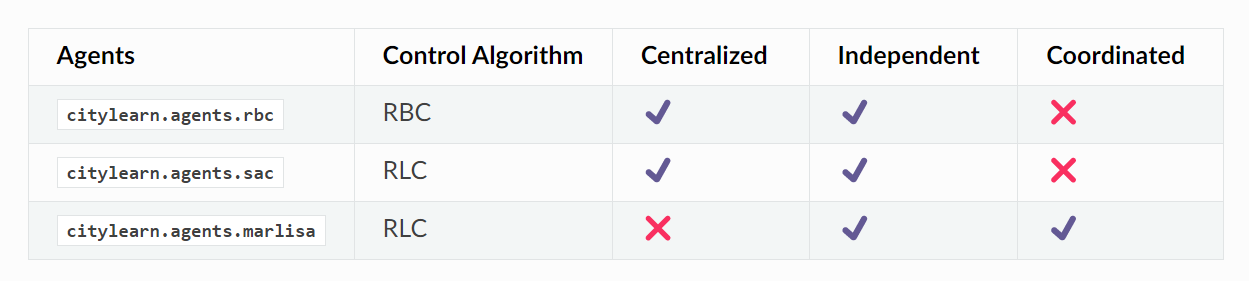

Of course, we can (and will) develop our own agents, but it is useful to know about some basic approaches to decision making.

To run a simulation, we first need to load the agent that represents the approach by which the decisions are made

In [ ]:
model = env.load_agent()

The agent to be loaded is defined in the schema.json file. Here, the agent that is loaded is a BasicRBC agent



```
"agent": {
    "type": "citylearn.agents.rbc.BasicRBC",
    "attributes": {
      "hidden_dimension": [
        256,
        256
      ],
      "discount": 0.99,
      "tau": 0.005,
      "lr": 0.003,
      "batch_size": 256,
      "replay_buffer_capacity": 100000.0,
      "start_training_time_step": 6000,
      "end_exploration_time_step": 7000,
      "deterministic_start_time_step": 26280,
      "action_scaling_coef": 0.5,
      "reward_scaling": 5.0,
      "update_per_time_step": 2
    }
  }



One of the actions in the framework (which is the only one that is active by default) defines the amount of electricity that is charged/discharged from the battery. The decision rule here is very simple: the amount is -0.08 (discharge), 0.091 (charge) or 0 (no-op), depending on the hour of day.



```
for n, o, d in zip(self.observation_names, observations, self.action_dimension):
    hour = o[n.index('hour')]

    # Daytime: release stored energy
    if hour >= 9 and hour <= 21:
        a = [-0.08 for _ in range(d)]

    # Early nightime: store DHW and/or cooling energy
    elif (hour >= 1 and hour <= 8) or (hour >= 22 and hour <= 24):
        a = [0.091 for _ in range(d)]

    else:
        a = [0.0 for _ in range(d)]

    actions.append(a)

```




We can change the agent we are using.

In [ ]:
from citylearn.agents.rbc import RBC as RBCAgent
from citylearn.agents.rlc import RLC as RLCAgent

env.reset()
agents = {"RBC": RBCAgent(env), "RLC": RLCAgent(env)}

Now, let's see how to train our agent.
The learning process is detailed in the agent's function **learn** of the agent.

In [ ]:
model.learn(episodes=1, deterministic_finish=False)

The learn method includes an outer loop that runs for the number of episodes specified, and trains the agent for each episodes as follows:



```

            while not self.env.done:
                actions = self.predict(observations, deterministic=deterministic)

                # apply actions to citylearn_env
                next_observations, rewards, _, _ = self.env.step(actions)

                # update
                if not deterministic:
                    self.update(observations, actions, rewards, next_observations, done=self.env.done)
                else:
                    pass

                observations = [o for o in next_observations]



```



As can be seen above, the agent predicts (decides on) the next action to perform, applies it and updates its policy based on the observation and reward recevied. Note that in the case of the BasicRBC agent the agent does not update its policy.

After the agent is done training, its time to evaluate its performance

In [ ]:
print(env.evaluate())

⚠️ NOTE: Each agent implemented throughout the tutorial inherits from the agent base class, which is a part of the CityLearn environment. One of the functions of the agent base class is learn which is used to train the agent in collaboration with the environment. We utilize this function to train our agents, and you can find the complete implementation of the base agent class here: Source code for citylearn.agents.base

To initialize an environment, we call the `citylearn.citylearn.CityLearnEnv.__init__` method and parse the `schema` to it:

In [ ]:
env = CityLearnEnv(schema)
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Common (shared) observations amogst buildings:', env.shared_observations)
print('Number of buildings:', len(env.buildings))

NameError: ignored

In [ ]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage capacity history:', {
    b.name: b.electrical_storage.capacity_history for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage initial_soc:', {
    b.name: b.electrical_storage.initial_soc for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage efficiency history:', {
    b.name: b.electrical_storage.efficiency_history for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print()
# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})



---



# Writing Your Own Agent

#Using a Q-Learning Agent

We will discretize the hour into 24 bins and the action into 12 bins.
When we discretize the action into 12 bins, it means that we divide the continuous action space into 12 equally spaced intervals or bins. Each bin represents a discrete action that the agent can take. By discretizing the action space, we are essentially reducing the infinite number of possible continuous actions into a finite set of discrete actions.The agent can choose one of these discrete levels to adjust the battery state of each building.. Hour is an observation shared by all buildings thus, its values are the same in all buildings at each time step. For this reason, one of the dimensions of our Q-Table will equal hour bin count. The action space for controlling the batteries has the same size as number of buildings thus when discretized, the other Q-Table dimension will equal the electrical_storage action raised to the power of building count:

In [ ]:
tql_env = CityLearnEnv(schema)
# define active observations and actions and their bin sizes
observation_bins = {'hour': 24}
action_bins = {'electrical_storage': 12}

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

tql_env = TabularQLearningWrapper(
    tql_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


We now evaluate the trained model:

Building-level KPIs:


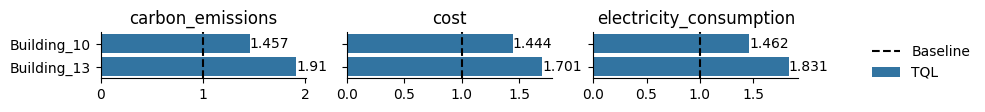

Building-level load profiles:


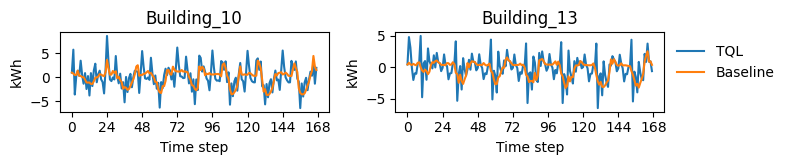

Battery SoC profiles:


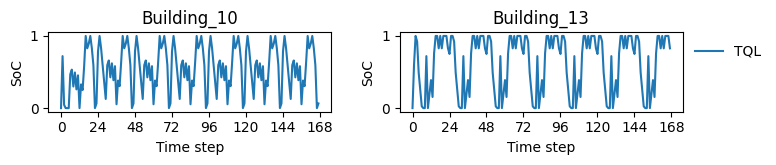

District-level KPIs:


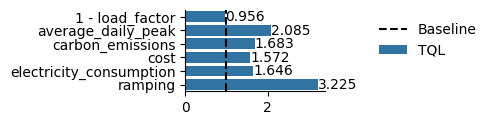

District-level load profiles:


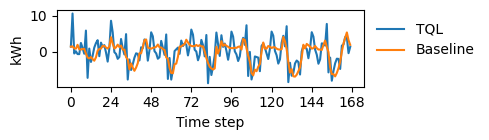

In [ ]:
observations = tql_env.reset()

while not tql_env.done:
    actions = tql_model.predict(observations, deterministic=True)
    observations, _, _, _ = tql_env.step(actions)

# plot summary and compare with other control results
plot_simulation_summary({'TQL': tql_env})

The figures plotted for the Tabular Q-Learning are compared against the baseline. The Q-Learning agent has performed worse than the baseline in terms of the building-level and district-level KPIs. The net electricity consumption profile as a result of the Q-Learning agent shows unstable and spiky consumption. The reason for this behavior is seen in the battery SoC curves where the changes in SoC are abrupt. This highlights an issue with our discretized action space having too large steps as trade off for maintaining a reasonably-sized Q-Table. We also see that the agent did not learn the unique day-to-day building needs as the SoC profile is identical every 24 time steps. This is a consequence of using a single observation, hour to learn.

In [ ]:
class TabularQLearning(Agent):
    def __init__(
        self, *args, epsilon: float = None, minimum_epsilon: float = None, epsilon_decay: float = None,
        learning_rate: float = None, discount_factor: float = None, q_init_value: float = 0, **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.epsilon = 1.0 if epsilon is None else epsilon
        self.epsilon_init = self.epsilon
        self.minimum_epsilon = 0.01 if minimum_epsilon is None else minimum_epsilon
        self.epsilon_decay = 0.0001 if epsilon_decay is None else epsilon_decay
        self.learning_rate = 0.05 if learning_rate is None else learning_rate
        self.discount_factor = 0.90 if discount_factor is None else discount_factor
        self.q_init_value = np.nan if q_init_value is None else q_init_value
        self.q = self.__initialize_q()


    def predict(self, observations: List[List[float]], deterministic: bool = None) -> List[List[float]]:

        actions = None
        seed = self.random_seed if self.random_seed is None else self.random_seed + self.time_step
        np.random.seed(seed)


        if deterministic or np.random.random() > self.epsilon:
            # Use q-function to decide action
            actions = self.exploit(observations)

        else:
            # Explore random action
            actions = [[s.sample()] for s in self.env.action_space]

        # exponential decay
        episode = int(self.time_step/self.env.time_steps)
        self.epsilon = max(self.minimum_epsilon, self.epsilon_init*np.exp(-self.epsilon_decay*episode))

        self.actions = actions
        self.next_time_step()
        return actions

    def exploit(self, observations: List[List[float]]) -> List[List[float]]:
        actions = []

        for i, o in enumerate(observations):
          o = o[0]
          a = np.argmax(self.q[i][o])
          actions.append([a])
        return actions

    def update(self, observations: List[List[float]], actions: List[List[float]], reward: List[float], next_observations: List[List[float]], done: bool):
        # Compute temporal difference target and error to udpate q-function
        for i, (o, a, r, n) in enumerate(zip(observations, actions, reward, next_observations)):
            o, n, a = o[0], n[0], a[0]
            current_q = self.q[i][o, a]
            next_max_q = np.argmax(self.q[i][n])

            # update q
            new_q = current_q + self.learning_rate*(r + self.discount_factor*next_max_q - current_q)
            self.q[i][o, a] = new_q

    def __initialize_q(self) -> np.ndarray:
        q = [None for _ in self.env.observation_space]
        for i, (od, ad) in enumerate(zip(self.env.observation_space, self.env.action_space)):
            shape = (od.n, ad.n)
            q[i] = np.ones(shape=shape)*self.q_init_value
        return q

We can now go ahead to initialize our Q Learner. We will modify the CityLearn `TabularQLearning` class so that we are able to visually track the learning process as well as keep tabs on its cummulative reward as training episode go by. We also provide a `random_seed` instance variable that we set to the random seed you defined earlier. This random seed will ensure that each time this notebook is run, the epsilon-greedy action selections are reproducible. The modifications to the `TabularQLearning` class are done below:

In [ ]:
class CustomTabularQLearning(TabularQLearning):
    def __init__(
        self, env: CityLearnEnv, loader: IntProgress,
        random_seed: int = None, **kwargs
    ):
        r"""Initialize CustomRBC.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        random_seed: int
            Random number generator reprocucibility seed for
            eqsilon-greedy action selection.
        kwargs: dict
            Parent class hyperparameters
        """

        super().__init__(env=env, random_seed=random_seed, **kwargs)
        self.loader = loader
        self.reward_history = []

    def next_time_step(self):
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1
        super().next_time_step()

With our Tabular Q-Learning agent set up, it is time to train it on our environment. We will use the following hyperparameters:

- `epsilon` ($\epsilon$) = 1.0
- `minimum_epsilon` ($\epsilon_{\textrm{min}}$) = 0.01
- `epsilon_decay` ($\epsilon_{\textrm{decay}}$) = 0.0001
- `discount_factor` ($\gamma$) = 0.99
- `learning_rate` ($\alpha$) = 0.005

The agent is trained for $\frac{m \times n \times i}{t}$ episodes where $m$ and $n$ are the observation and action space sizes respectively, $i$ is an arbitrary integer and t is the number of time steps in one episode. That way, we increase the probability that we at least visit each state-action combination once.

In [ ]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
i = 5
m = tql_env.observation_space[0].n
n = tql_env.action_space[0].n
t = tql_env.time_steps - 1
tql_episodes = m*n*i/t
tql_episodes = int(tql_episodes)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', tql_episodes)

# ------------------------------- SET LOADER ------------------------------
loader = get_loader(max=tql_episodes*t)
display(loader)

# ----------------------- SET MODEL HYPERPARAMETERS -----------------------
tql_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

# ----------------------- INITIALIZE AND TRAIN MODEL ----------------------
tql_model = CustomTabularQLearning(
    env=tql_env,
    loader=loader,
    random_seed=RANDOM_SEED,
    **tql_kwargs
)
_ = tql_model.learn(episodes=tql_episodes)

Q-Table dimension: (24, 144)
Number of episodes to train: 103


IntProgress(value=0, description='Simulating:', max=17201, style=ProgressStyle(bar_color='maroon'))